# Предсказание совершения пользователем целевого действия на сайте

*В данной работе необходимо предсказать совершение целевого действия пользователя (задача бинарной классификации). Датасет предоставлен Skillbox.*

## Содержание <a class="anchor" id="0"></a>

1. [Описание признаков](#1)
2. [Импорты библиотек](#2)
3. [Загрузка и исследование данных](#3)
4. [Подготовка данных](#4)
   - 4.1 [Очистка данных](#4.1)
   - 4.2 [Визуализация](#4.2)
   - 4.3 [Создание новых признаков](#4.3)
5. [Моделирование](#5)
   - 5.1 [Базовые оценки](#5.1)
   - 5.2 [SGDClassifier](#5.2)
   - 5.3 [LogisticRegression](#5.3)
   - 5.4 [LinearSVC](#5.4)
   - 5.5 [RandomForestClassifier](#5.5)
   - 5.6 [VotingClassifier](#5.6)
   - 5.7 [Тест полученных моделей](#5.7)
   - 5.8 [XGBClassifier](#5.8)
   - 5.9 [LGBMClassifier](#5.9)
6. [Валидация](#6)
7. [Заключение](#7)

## 1. Описание признаков <a class="anchor" id="1"></a>

[Наверх](#0)

*Описание атрибутов датасета _GA Sessions_*
1) **session_id** — *ID визита;*
2) **client_id** — *ID посетителя;*
3) **visit_date** — *дата визита;*
4) **visit_time** — *время визита;*
5) **visit_number** — *порядковый номер визита клиента;*
6) **utm_source** — *канал привлечения;*
7) **utm_medium** — *тип привлечения;*
8) **utm_campaign** — *рекламная кампания;*
9) **utm_keyword** — *ключевое слово;*
10) **device_category** — *тип устройства;*
11) **device_os** — *ОС устройства;*
12) **device_brand** — *марка устройства;*
13) **device_model** — *модель устройства;*
14) **device_screen_resolution** — *разрешение экрана;*
15) **device_browser** — *браузер;*
16) **geo_country** — *страна;*
17) **geo_city** — *город.*

*Описание атрибутов датасета _GA Hits_*
1) **session_id** — *ID визита;*
2) **hit_date** — *дата события;*
3) **hit_time** — *время события;*
4) **hit_number** — *порядковый номер события в рамках сессии;*
5) **hit_type** — *тип события;*
6) **hit_referer** — *источник события;*
7) **hit_page_path** — *страница события;*
8) **event_category** — *тип действия;*
9) **event_action** — *действие;*
10) **event_label** — *тег действия;*
11) **event_value** — *значение результата действия.*

## 2. Импорты библиотек <a class="anchor" id="2"></a>

[Наверх](#0)

In [2]:
# Для ускорения работы LogisticRegression, SVC и RandomForestClassifier
#from sklearnex import patch_sklearn
#patch_sklearn()

In [4]:
import datetime
from functools import partial
import dill

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from hyperopt import hp, fmin, tpe, Trials, STATUS_OK

# Требуется для sklearnex
#import sklearn
#assert sklearn.__version__ <= '1.0.2'

from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, 
                             precision_score, recall_score, 
                             f1_score, roc_auc_score)
from sklearn.model_selection import (cross_val_score, train_test_split, 
                                     StratifiedKFold)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, 
                                   StandardScaler)
from sklearn.svm import LinearSVC, SVC
from sklearn.tree import DecisionTreeClassifier, ExtraTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

import warnings
warnings.filterwarnings('ignore')

In [4]:
# Требуется для версии sklearn 1.0.2
#from sklearn import set_config
#set_config(display="diagram")

## 3. Загрузка и исследование данных <a class="anchor" id="3"></a>

[Наверх](#0)

Загружаем данные из ga_sessions

In [11]:
sessions = pd.read_csv('data/ga_sessions.csv', sep=',')
sessions.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow


In [12]:
sessions.shape

(1860042, 18)

Рассмотрим датасет подробнее

In [13]:
sessions.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1860042 entries, 0 to 1860041
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1860042 non-null  object
 1   client_id                 1860042 non-null  object
 2   visit_date                1860042 non-null  object
 3   visit_time                1860042 non-null  object
 4   visit_number              1860042 non-null  int64 
 5   utm_source                1859945 non-null  object
 6   utm_medium                1860042 non-null  object
 7   utm_campaign              1640439 non-null  object
 8   utm_adcontent             1524427 non-null  object
 9   utm_keyword               777981 non-null   object
 10  device_category           1860042 non-null  object
 11  device_os                 789904 non-null   object
 12  device_brand              1492864 non-null  object
 13  device_model              16338 non-null  

Видим, что есть пропущенные значения. 

In [14]:
sessions.describe()

,visit_number
count,1.860042e+06
mean,2.712804e+00
std,1.182907e+01
min,1.000000e+00
25%,1.000000e+00
50%,1.000000e+00
75%,2.000000e+00
max,5.640000e+02


В среднем пользователем совершается 2.7 визита на сайт. Медианное значение один визит. При этом видно, что какой-то пользователь совершил аж 564 визита! Этот пользователь возможно является ботом.

In [15]:
sessions.describe(include='object').T

,count,unique,top,freq
session_id,1860042,1860042,9055434745589932991.1637753792.1637753792,1
client_id,1860042.0,1391717.0,1750498477.162945,462.0
visit_date,1860042,226,2021-05-24,39453
visit_time,1860042,85318,12:00:00,61067
utm_source,1859945,293,ZpYIoDJMcFzVoPFsHGJL,578290
utm_medium,1860042,56,banner,552272
utm_campaign,1640439,412,LTuZkdKfxRGVceoWkVyg,463481
utm_adcontent,1524427,286,JNHcPlZPxEMWDnRiyoBf,1006599
utm_keyword,777981,1219,puhZPIYqKXeFPaUviSjo,506819
device_category,1860042,3,mobile,1474871


Можно заметить, что все значения **session_id** уникальны, а **client_id** нет. Значит, у одного пользователя может быть более одного визита, что вполне логично. Убедимся, что все **session_id** для каждого **client_id** уникальны.

In [16]:
sessions.groupby('client_id')['session_id'].value_counts().max()

1

Всё нормально, и судя по всему дубликатов тоже нет. Но для чистоты эксперимаента проверим

In [17]:
sessions.duplicated().sum()

0

Что ещё интересного можно увидеть из представленных данных:
- количество клиентов примерно 1,4 млн;
- данные представлены за период в 226 дней;
- наибольшее количество привлечений через рекламные баннеры;
- пользователи в основном заходят с мобильных устройств на базе ОС Android;
- самым популярным брендом мобильного устройства является Apple;
- в основном посетители из России, из них почти половина из Москвы.

Загружаем данные из ga_hits

In [18]:
hits = pd.read_csv('data/ga_hits.csv', sep=',')
hits.head()

,session_id,hit_date,hit_time,hit_number,hit_type,hit_referer,hit_page_path,event_category,event_action,event_label,event_value
0,5639623078712724064.1640254056.1640254056,2021-12-23,597864.0,30,event,NaN,sberauto.com/cars?utm_source_initial=google&ut...,quiz,quiz_show,NaN,NaN
1,7750352294969115059.1640271109.1640271109,2021-12-23,597331.0,41,event,NaN,sberauto.com/cars/fiat?city=1&city=18&rental_c...,quiz,quiz_show,NaN,NaN
2,885342191847998240.1640235807.1640235807,2021-12-23,796252.0,49,event,NaN,sberauto.com/cars/all/volkswagen/polo/e994838f...,quiz,quiz_show,NaN,NaN
3,142526202120934167.1640211014.1640211014,2021-12-23,934292.0,46,event,NaN,sberauto.com/cars?utm_source_initial=yandex&ut...,quiz,quiz_show,NaN,NaN
4,3450086108837475701.1640265078.1640265078,2021-12-23,768741.0,79,event,NaN,sberauto.com/cars/all/mercedes-benz/cla-klasse...,quiz,quiz_show,NaN,NaN


In [19]:
hits.shape

(15726470, 11)

Размер датасета внушительный!

In [20]:
hits.info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15726470 entries, 0 to 15726469
Data columns (total 11 columns):
 #   Column          Non-Null Count     Dtype  
---  ------          --------------     -----  
 0   session_id      15726470 non-null  object 
 1   hit_date        15726470 non-null  object 
 2   hit_time        6566148 non-null   float64
 3   hit_number      15726470 non-null  int64  
 4   hit_type        15726470 non-null  object 
 5   hit_referer     9451666 non-null   object 
 6   hit_page_path   15726470 non-null  object 
 7   event_category  15726470 non-null  object 
 8   event_action    15726470 non-null  object 
 9   event_label     11966286 non-null  object 
 10  event_value     0 non-null         float64
dtypes: float64(2), int64(1), object(8)
memory usage: 1.3+ GB


Датасет **ga_hits** представляет собой сводную статистику активности пользователей на сайте. Данную активность нам как раз и нужно будет предсказать. Поэтому из данного датасета для нас ценность представляют только метки. Их, в свою очередь, нужно будет подготовить, выполнив определённые манипуляции с данными.

In [21]:
hits.describe()

,hit_time,hit_number,event_value
count,6.566148e+06,1.572647e+07,0.0
mean,2.091050e+05,2.356715e+01,NaN
std,4.032110e+05,2.887713e+01,NaN
min,0.000000e+00,1.000000e+00,NaN
25%,2.412000e+04,7.000000e+00,NaN
50%,8.994100e+04,1.500000e+01,NaN
75%,2.195352e+05,2.900000e+01,NaN
max,1.315688e+07,5.000000e+02,NaN


In [22]:
hits.describe(include='object').T

,count,unique,top,freq
session_id,15726470,1734610,5442565791571325612.1632449195.1632449195,768
hit_date,15726470,226,2021-05-24,513035
hit_type,15726470,1,event,15726470
hit_referer,9451666,37873,HbolMJUevblAbkHClEQa,8879187
hit_page_path,15726470,342715,podpiska.sberauto.com/,2793639
event_category,15726470,52,card_web,7456998
event_action,15726470,230,view_card,3558985
event_label,11966286,39825,KclpemfoHstknWHFiLit,6505447


Как видно, количество уникальных значений **session_id** в **ga_hits** меньше, чем в **ga_sessions**. То есть получается, что в **ga_sessions** есть визиты на сайт, которые неизвестно чем закончились, и, возможно, наоборот - есть события в **ga_hits**, о причинах которых ничего неизвестно. Таким образом, в датасетах есть строки, которые интереса для нас не представляют! Учтём это при слиянии.

Теперь создадим столбец, содержащий целевые значения

In [23]:
# Список целевых действий из ga_hits.event_action согласно задания
target_events = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

In [24]:
# Столбец с метками (1 - совершено целевое действие, 0 - нет)
hits['target'] = hits.event_action.isin(target_events).astype(int)

Посмотрим, как распределены целевые действия

In [25]:
hits[hits.target == 1].event_action.value_counts()

sub_car_claim_click                 37928
sub_open_dialog_click               25870
sub_submit_success                  18439
sub_car_claim_submit_click          12359
sub_call_number_click                3653
sub_callback_submit_click            3074
sub_car_request_submit_click         2966
sub_custom_question_submit_click      619
Name: event_action, dtype: int64

Теперь сгруппируем данные по **session_id** и произведём суммирование по **target**. Если сумма больше 0, значит было совершено, как минимум, одно целевое действие на сайте. В этом случае присваиваем 1, в противном случае - 0.

In [33]:
hits_group = hits.groupby('session_id')['target'].sum().map(lambda x: 1 if x>0 else 0)

Теперь объединим объект DataFrame **sessions** и объект Series **hits_group**

In [35]:
df = pd.merge(sessions, hits_group, on='session_id', how='inner')
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.163776,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.163687,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.162225,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.162225,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


In [36]:
df.shape

(1732266, 19)

Как видно, к DataFrame **sessions** добавился столбец **target** с целевыми значенимя

Теперь сравним количество визитов с целевыми действиями и без

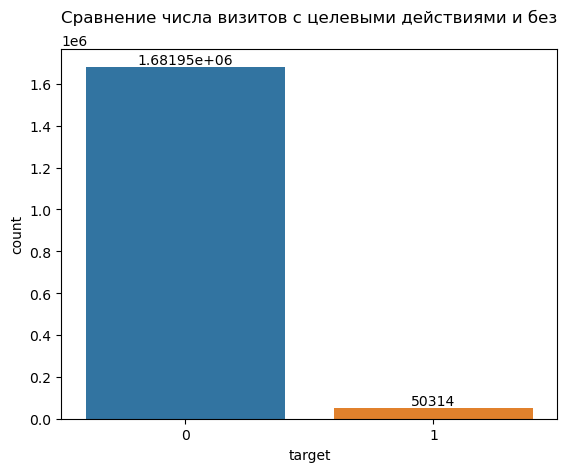

In [37]:
g = sns.countplot(x='target', data=df)
for container in g.containers:
    g.bar_label(container)
plt.title('Сравнение числа визитов с целевыми действиями и без', y=1.05);

Разница огромная! Посчитаем процентное соотношение

In [38]:
df.target.value_counts()[1] / df.target.value_counts()[0] *100

2.9914052244059284

Всего 3 % визитов заканчивается целевыми действиями. Это очень мало! Имеет место дисбаланс классов

Сохраним текущий обработанный датасет и будем его загружать в дальнейшем

In [6]:
df = pd.read_csv('data/sberauto.csv', dtype={'client_id': object}, sep=',')

## 4. Подготовка данных <a class="anchor" id="4"></a>

### 4.1 Очистка данных <a class="anchor" id="4.1"></a>

[Наверх](#0)

In [5]:
# Если выполнялись шаги раздела выше, то данную ячейку пропустить
df = pd.read_csv('data/sberauto.csv', dtype={'client_id': object}, sep=',')
df.head()

,session_id,client_id,visit_date,visit_time,visit_number,utm_source,utm_medium,utm_campaign,utm_adcontent,utm_keyword,device_category,device_os,device_brand,device_model,device_screen_resolution,device_browser,geo_country,geo_city,target
0,9055434745589932991.1637753792.1637753792,2108382700.1637757,2021-11-24,14:36:32,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Zlatoust,0
1,905544597018549464.1636867290.1636867290,210838531.16368672,2021-11-14,08:21:30,1,MvfHsxITijuriZxsqZqt,cpm,FTjNLDyTrXaWYgZymFkV,xhoenQgDQsgfEPYNPwKO,IGUCNvHlhfHpROGclCit,mobile,Android,Samsung,NaN,385x854,Samsung Internet,Russia,Moscow,0
2,9055446045651783499.1640648526.1640648526,2108385331.164065,2021-12-28,02:42:06,1,ZpYIoDJMcFzVoPFsHGJL,banner,LEoPHuyFvzoNfnzGgfcd,vCIpmpaGBnIQhyYNkXqp,puhZPIYqKXeFPaUviSjo,mobile,Android,Huawei,NaN,360x720,Chrome,Russia,Krasnoyarsk,0
3,9055447046360770272.1622255328.1622255328,2108385564.1622252,2021-05-29,05:00:00,1,kjsLglQLzykiRbcDiGcD,cpc,NaN,NOBKLgtuvqYWkXQHeYWM,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0
4,9055447046360770272.1622255345.1622255345,2108385564.1622252,2021-05-29,05:00:00,2,kjsLglQLzykiRbcDiGcD,cpc,NaN,NaN,NaN,mobile,NaN,Xiaomi,NaN,393x786,Chrome,Russia,Moscow,0


Прежде чем приступить к работе с данными, разделим наш датасет на тестовый и тренировочный, чтобы свести к нулю возможность оказания влияния на тестовый датасет. Все манипуляции исключительно будем проводить на тренировочном датасете.

In [6]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42, stratify=df.target)

Вычислим процент пропущенных значений по столбцам

In [7]:
df_train.isna().sum()[df_train.isna().sum()>0].div(df_train.shape[0]/100).sort_values(ascending=False)

device_model     99.128020
utm_keyword      58.909434
device_os        58.515657
device_brand     20.041896
utm_adcontent    17.526836
utm_campaign     11.246764
utm_source        0.004763
dtype: float64

Как видно, в трёх столбцах процент пропущенных значений больше 50%. Однозначно столбец **device_model** подлежит удалению. По остальным двум столбцам вопрос остается открытым. 

In [8]:
# Удаляем признак device_model
df_train = df_train.drop('device_model', axis=1)

Ещё раз посмотрим на столбцы и типы данных

In [9]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385812 entries, 235446 to 1155565
Data columns (total 18 columns):
 #   Column                    Non-Null Count    Dtype 
---  ------                    --------------    ----- 
 0   session_id                1385812 non-null  object
 1   client_id                 1385812 non-null  object
 2   visit_date                1385812 non-null  object
 3   visit_time                1385812 non-null  object
 4   visit_number              1385812 non-null  int64 
 5   utm_source                1385746 non-null  object
 6   utm_medium                1385812 non-null  object
 7   utm_campaign              1229953 non-null  object
 8   utm_adcontent             1142923 non-null  object
 9   utm_keyword               569438 non-null   object
 10  device_category           1385812 non-null  object
 11  device_os                 574895 non-null   object
 12  device_brand              1108069 non-null  object
 13  device_screen_resolution  1385812 non

Можно заметить, что **visit_date** и **visit_time** имеют тип данных **object**. Их нужно будет привести к формату даты.

In [10]:
df_train.nunique()

session_id                  1385812
client_id                   1092593
visit_date                      226
visit_time                    84075
visit_number                    501
utm_source                      263
utm_medium                       52
utm_campaign                    400
utm_adcontent                   270
utm_keyword                    1139
device_category                   3
device_os                        13
device_brand                    189
device_screen_resolution       4430
device_browser                   53
geo_country                     154
geo_city                       2201
target                            2
dtype: int64

Очень много уникальных значений у **device_screen_resolution**. Скорей всего данный признак не самый информативный, поэтому удалим его. Что касается признаков **session_id** и **client_id**, то их пока оставим, так как возможно они нам понадобятся при создании новых признаков. Непосредственно перед моделированием, эти признаки так же будут удалены.

In [11]:
# Удаляем признак device_screen_resolution
df_train = df_train.drop('device_screen_resolution', axis=1)

Преобразуем данные из столбцов **visit_date** и **visit_time** в формат datetime

In [12]:
df_train['visit_date'] = pd.to_datetime(df_train.visit_date)
df_train['visit_time'] = pd.to_datetime(df_train.visit_time)

In [13]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1385812 entries, 235446 to 1155565
Data columns (total 17 columns):
 #   Column           Non-Null Count    Dtype         
---  ------           --------------    -----         
 0   session_id       1385812 non-null  object        
 1   client_id        1385812 non-null  object        
 2   visit_date       1385812 non-null  datetime64[ns]
 3   visit_time       1385812 non-null  datetime64[ns]
 4   visit_number     1385812 non-null  int64         
 5   utm_source       1385746 non-null  object        
 6   utm_medium       1385812 non-null  object        
 7   utm_campaign     1229953 non-null  object        
 8   utm_adcontent    1142923 non-null  object        
 9   utm_keyword      569438 non-null   object        
 10  device_category  1385812 non-null  object        
 11  device_os        574895 non-null   object        
 12  device_brand     1108069 non-null  object        
 13  device_browser   1385812 non-null  object        
 1

Теперь из столбцов **visit_date** и **visit_time** выделим число, месяц, день недели и время (час) визита

In [14]:
# Номер дня недели (0 - понедельник, 6 - воскресенье)
df_train['visit_weekday'] = df_train.visit_date.dt.weekday.astype(int)

In [15]:
# Число
df_train['visit_day'] = df_train.visit_date.dt.day.astype(int)

In [16]:
# Месяц
df_train['visit_month'] = df_train.visit_date.dt.month.astype(int)

In [17]:
# Час
df_train['visit_hour'] = df_train.visit_time.dt.hour.astype(int)

In [18]:
df_train.dtypes

session_id                 object
client_id                  object
visit_date         datetime64[ns]
visit_time         datetime64[ns]
visit_number                int64
utm_source                 object
utm_medium                 object
utm_campaign               object
utm_adcontent              object
utm_keyword                object
device_category            object
device_os                  object
device_brand               object
device_browser             object
geo_country                object
geo_city                   object
target                      int64
visit_weekday               int32
visit_day                   int32
visit_month                 int32
visit_hour                  int32
dtype: object

Прежде чем заполнить пропущенные значения, попробуем визуализировать наши признаки

### 4.2 Визуализация <a class="anchor" id="4.2"></a>

[Наверх](#0)

Для начала, попробуем визуализировать категорийные признаки. Выберем те признаки, значения которых нам понятны

In [20]:
features = [
    'utm_medium', 
    'device_category', 
    'device_os', 
    'device_brand', 
    'device_browser', 
    'geo_country', 
    'geo_city',
    'target'
]

Так как у категорийных признаков очень много уникальных значений, выберем топ-5 значений для каждого признака. Остальные заменим значением other

In [21]:
df_cat = df_train[features].copy()
for feature in features:
    feat = df_train[feature].value_counts(ascending=False).index[5:]
    df_cat[feature].replace(feat, 'other', inplace=True)

Преобразуем DataFrame в long form

In [22]:
df_long = df_cat.melt(id_vars=['target'], value_vars=features)

Отсортируем значения для отображения на графиках

In [23]:
df_long['count'] = df_long.groupby(['variable', 'value']).value.transform('count')
df_long = df_long.sort_values(by='count', ascending=False)

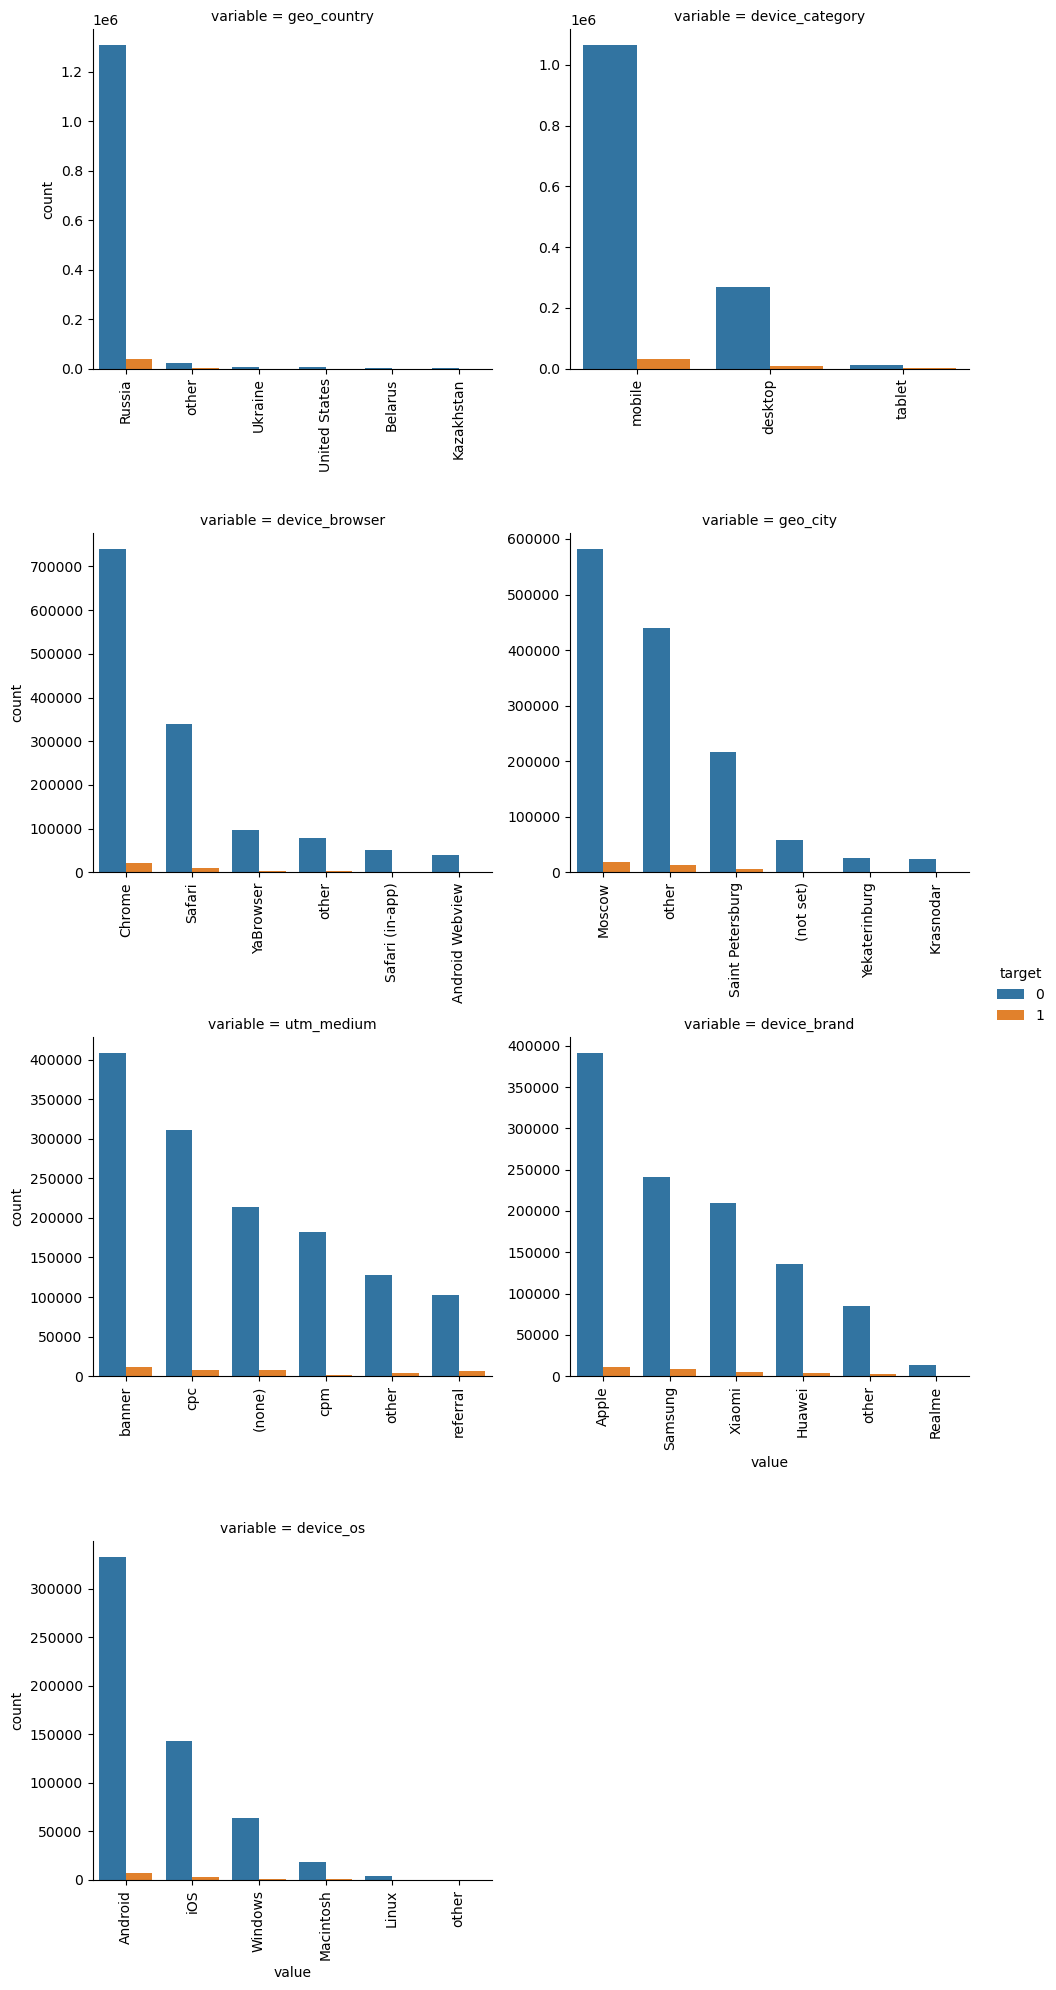

In [24]:
g=sns.catplot(
    x='value',
    data=df_long,
    hue='target',
    col='variable',
    kind='count',
    col_wrap=2,
    sharex=False,
    sharey=False,
)

g.set_xticklabels(rotation=90)
g.tight_layout();

Что можно заметить:
- Почти все визиты совершаются с территории России. Ожидаемо, наибольшее число визитов из Москвы. А суммарно на Москву и Санкт-Петербург визитов приходится больше, чем на остальные города.
- Больше всего визитов совершается с мобильных устройств, на втором месте стационарные устройства. 
- Самым популярным мобильным устройством является Apple. На втором месте Samsung, далее идут популярные китайские бренды. При этом iOS уступает лидерство ОС Android. 
- Среди ПК наиболее популярной ОС является Windows. Linux уступает даже Macintosh.
- По большей части визиты осуществляются через платный трафик (banner, cpc, cpm), но в топ-5 также присутствует и органический трафик (referral, none). При этом, видно, что количество визитов с целевыми действиями с органического трафика сравнимо с числом визитов с целевыми действиями с платного трафика.

Теперь рассмотрим, как те же признаки влияют на целевое значение

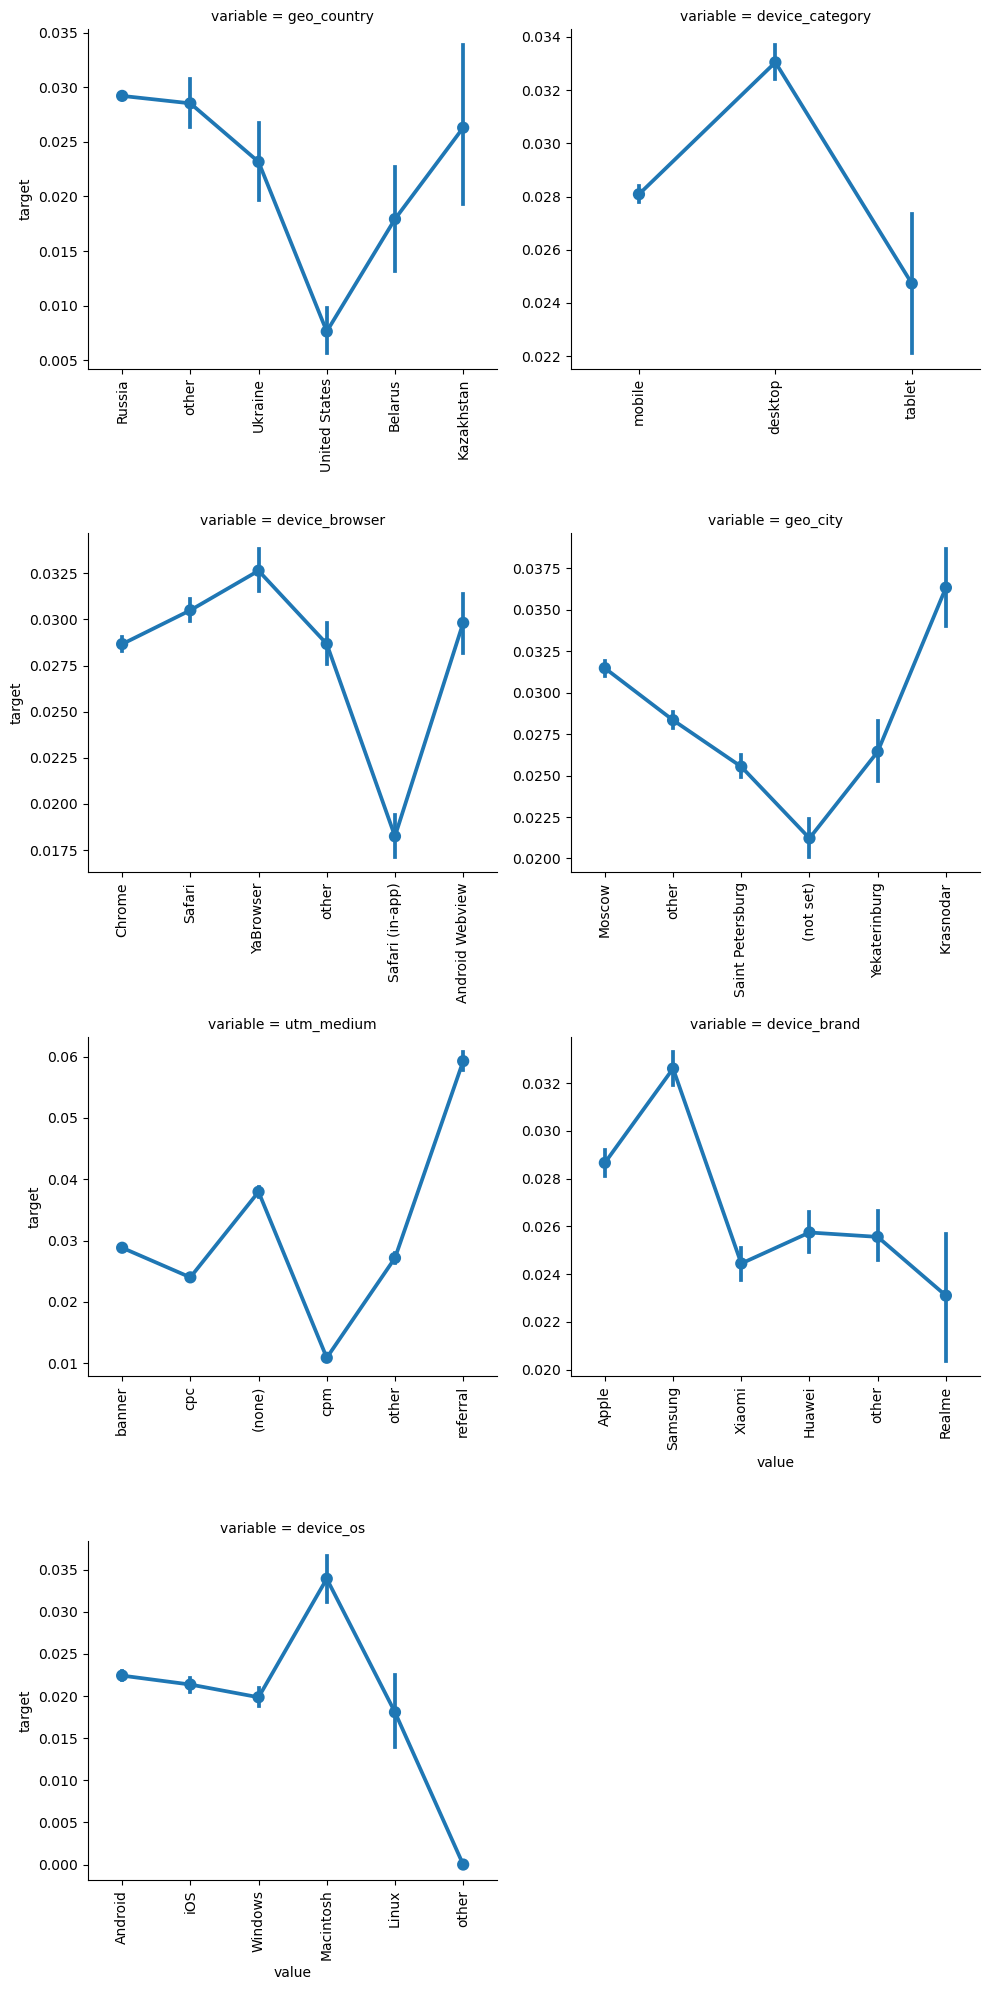

In [25]:
g=sns.catplot(
    x='value',
    y='target',
    data=df_long,
    col='variable',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)

g.set_xticklabels(rotation=90)
g.tight_layout();

Что можно заметить из этих графиков:
- В среднем целевых действий больше совершаются с территории России. При этом Москва незначительно уступает Краснодару.
- В среднем больше всего целевых действий осуществляется со стационарных устройств, а самым популярным браузером является браузер от Яндекса. 
- Среди мобильным устройством в среднем больше всего целевых действий осуществляется с Samsung. На втором месте Apple. При этом с Android и iOS в среднем совершается примерно равное количество целевых действий.
- Больше всего в среднем целевых действий осуществляется с ОС Macintosh, при этом она опережает даже Android и iOS.
- При этом можно заметить, что в среднем наибольшее число визитов у пользователей с органического трафика. Это вполне объяснимо, так как данная категория пользователей заходит на ресурс целенаправленно.

Таким образом, получается, что наибольшее число целевых действий совершают пользователи с высоким уровнем дохода. Этому свидетельствуют дорогие бренды мобильных и стационарных устройств, крупные города, в которых, как правило, в среднем доход жителей выше чем по стране. Это вполне объяснимо, так как стоимость автоподписки довольно высока и рассчитана на платёжеспособного жителя страны.

Теперь визуализируем числовые признаки

Рассмотрим распределение числа визитов

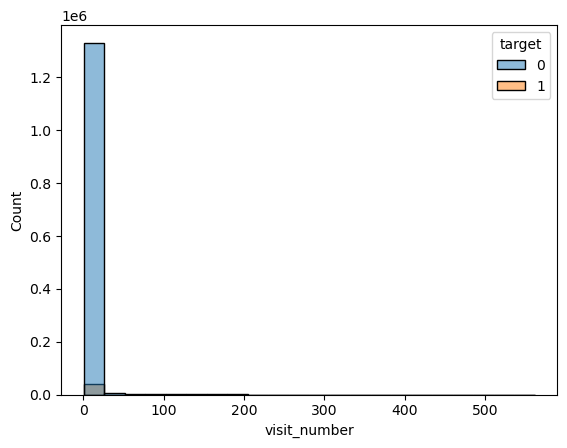

In [43]:
sns.histplot(
    data=df_train, 
    x='visit_number', 
    hue='target'
);

Рассмотрим в другом масштабе

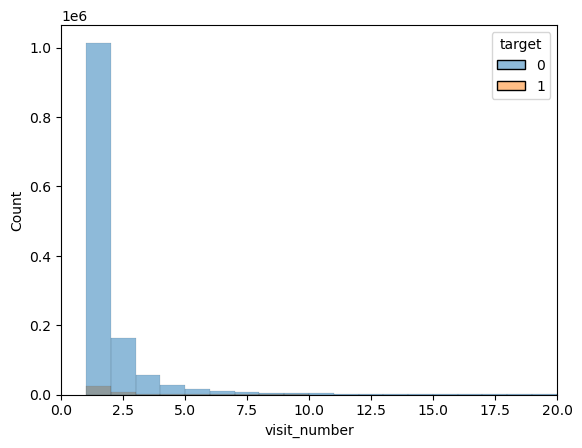

In [51]:
sns.histplot(
    data=df_train, 
    x='visit_number', 
    hue='target',
    bins=df_train.visit_number.max()
)
plt.xlim(0, 20);

Как видно, в большинстве случаев пользователи ограничиваются одним визитом

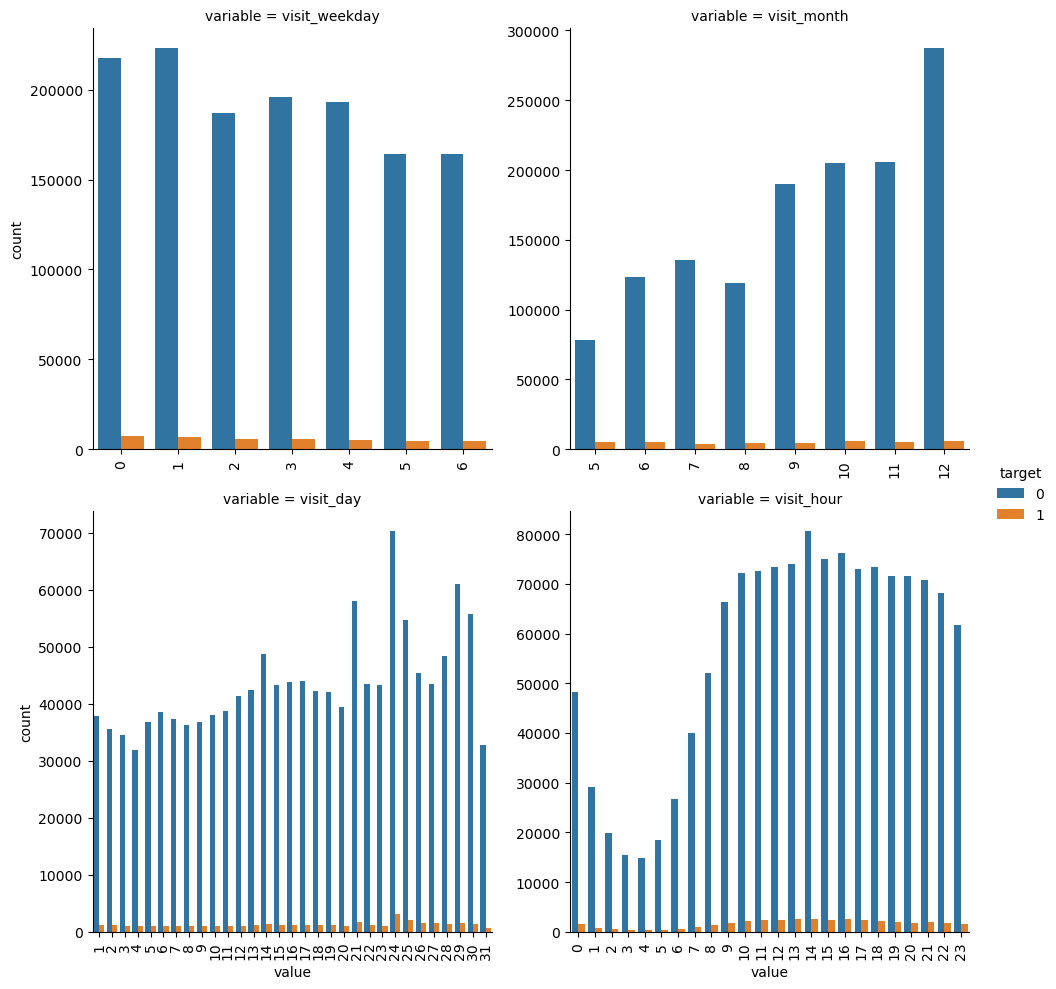

In [37]:
g=sns.catplot(
    x='value',
    data=df_train.melt(
        id_vars=['target'],
        value_vars=['visit_weekday', 'visit_month', 'visit_day', 'visit_hour']
    ),
    hue='target',
    col='variable',
    kind='count',
    col_wrap=2,
    sharex=False,
    sharey=False,
)

g.set_xticklabels(rotation=90)
g.tight_layout();

На что можно обратить внимание:
- К выходным число визитов немного снижается
- С мая по декабрь идёт рост числа визитов, за исключением августа. Возможно это связано с отпусками 
- Наибольшее число визитов совершается в дневное время, особенно с 13 до 14 часов

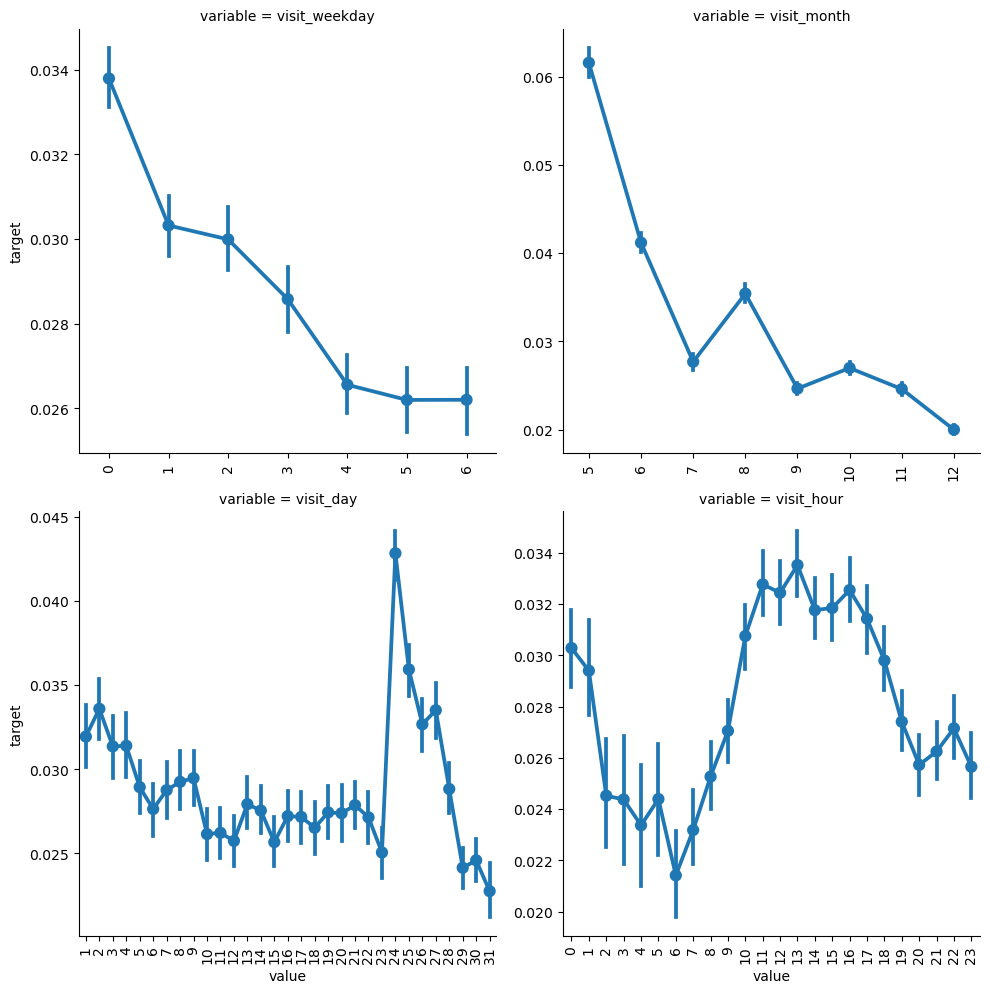

In [29]:
g=sns.catplot(
    x='value',
    y='target',
    data=df_train.melt(
        id_vars=['target'],
        value_vars=['visit_weekday', 'visit_month', 'visit_day', 'visit_hour']
    ),
    col='variable',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
);

Что можно заметить из этих графиков:
- В среднем целевых действий больше совершается в начале недели, особенно в понедельник
- В течение года среднее количество визитов с целевыми действиями уменьшается, за исключением августа. Из этого можно предположить, что это происходит за счёт роста общего числа визита (в августе как раз спад посещаемости)
- В среднем больше всего целевых действий осуществляется в начале месяца, но есть увеличение вблизи 25-го числа. Учитывая, что в декабре наибольшее число визитов, можно предположить, что данный всплеск связан с предновогодней активностью. 

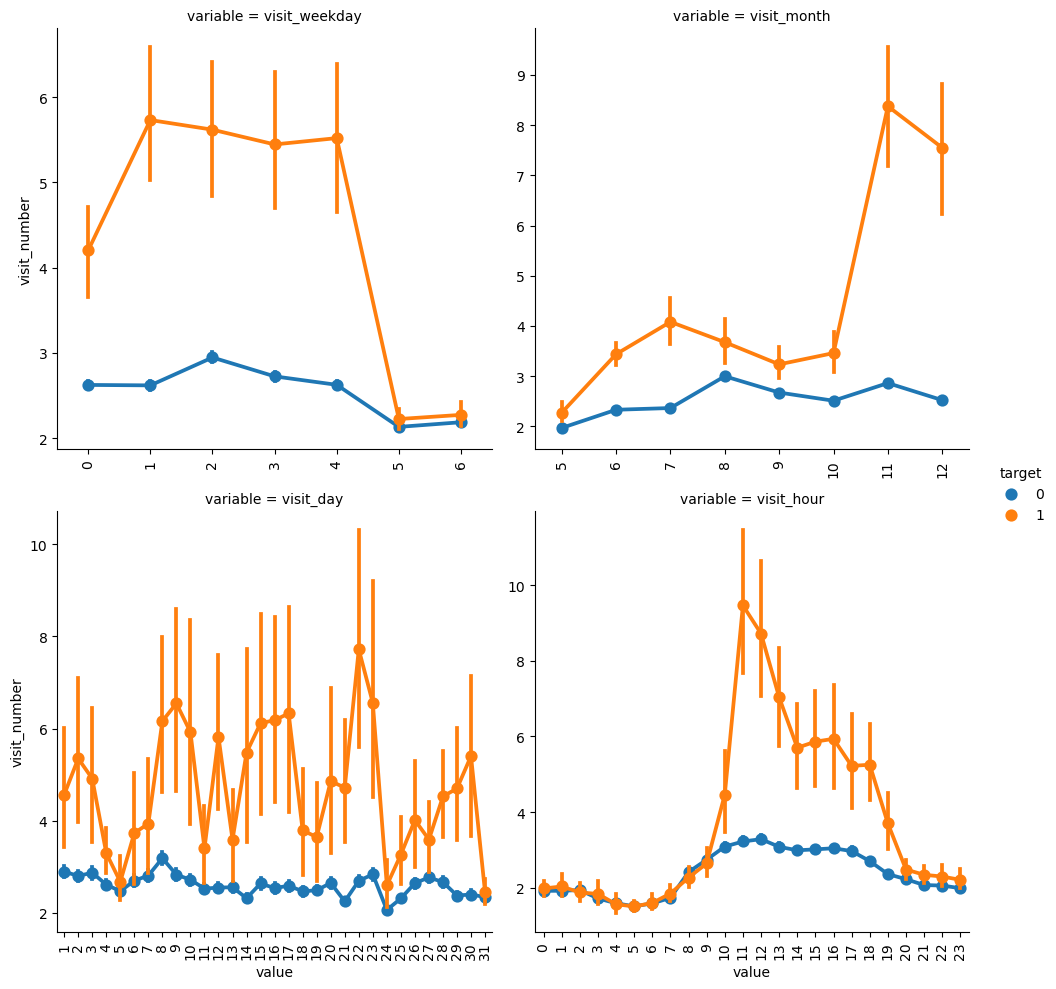

In [38]:
g=sns.catplot(
    x='value',
    y='visit_number',
    data=df_train.melt(
        id_vars=['visit_number', 'target'],
        value_vars=['visit_weekday', 'visit_month', 'visit_day', 'visit_hour']
    ),
    hue='target',
    col='variable',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
)

g.set_xticklabels(rotation=90)
g.tight_layout();

Из данных графиков можно заметить, что для совершения целевого действия в среднем требуется большее число визитов

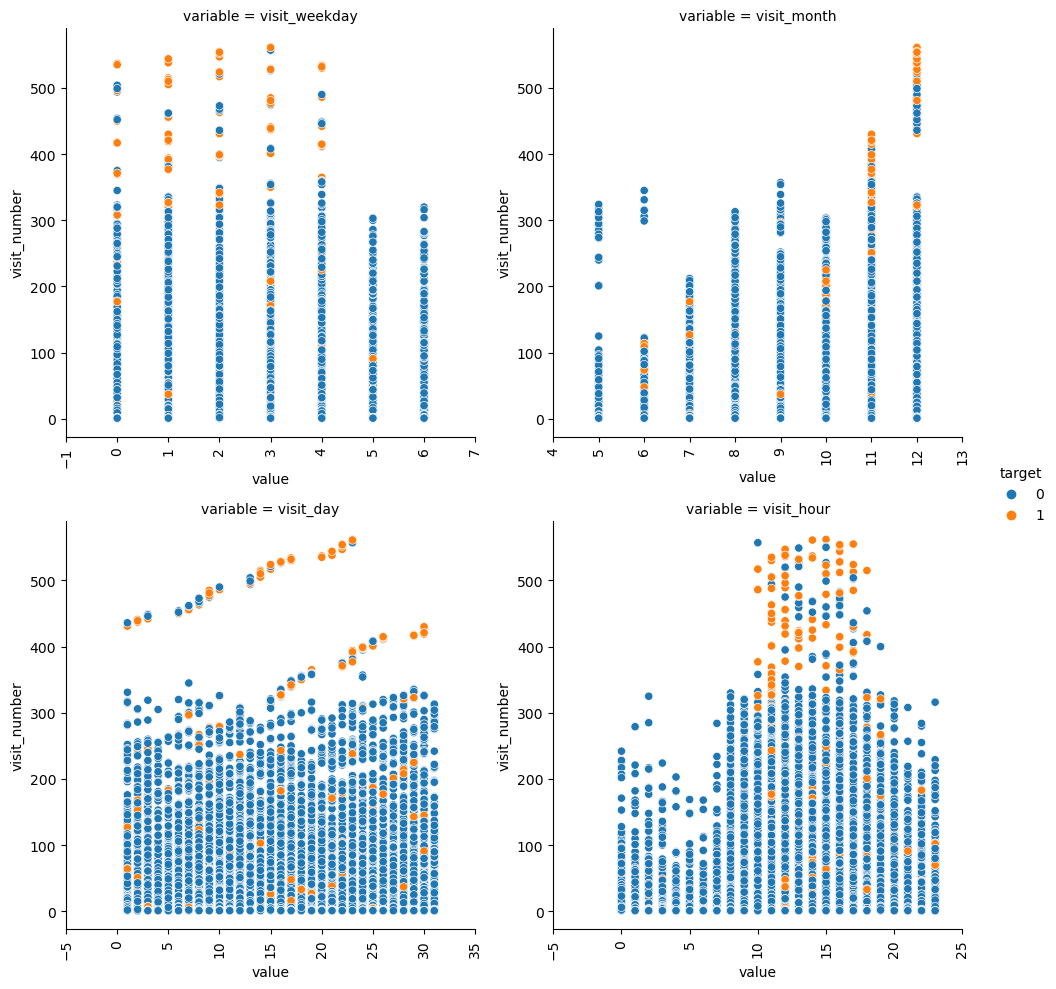

In [39]:
g=sns.relplot(
    x='value',
    y='visit_number',
    data=df_train.melt(
        id_vars=['visit_number', 'target'],
        value_vars=['visit_weekday', 'visit_month', 'visit_day', 'visit_hour']
    ),
    hue='target',
    col='variable',
    kind='scatter',
    col_wrap=2,
    facet_kws=dict(sharex=False, sharey=False),
)

g.set_xticklabels(rotation=90)
g.tight_layout();

Как видно, для визитов с большим номером характерно совершение целевого действия

### 4.3 Создание новых признаков <a class="anchor" id="4.3"></a>

[Наверх](#0)

Прежде чем приступить к созданию новых признаков, поробуем обучить базовые модели с текущими признаками. Но сначала необходимо заполнить все пропуски. Также необходимо масштабировать числовые признаки и закодировать категориальные. Зададим конвейеры обработки

In [19]:
# Категориальные признаки
cat_pipeline = Pipeline([
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("encoder", OneHotEncoder(sparse=True, handle_unknown='ignore')),
])

In [20]:
# Числовые признаки
num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('std_scaler', StandardScaler()),    
])

Для ускорения вычислений, проведём обучение на "урезанном" датасете. Выберем первые 100 тыс. значений

In [21]:
np.bincount(df_train[:100000].target)

array([96976,  3024], dtype=int64)

Целевые значения составляют примерно 3%, так что выборка подходит

In [22]:
X_train = df_train[:100000].drop('target', axis=1)
y_train = df_train[:100000].target.copy()

In [23]:
# Категориальные признаки
cat_columns = X_train.select_dtypes(object).columns[2:]
cat_columns

Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_browser', 'geo_country', 'geo_city'],
      dtype='object')

In [24]:
# Числовые признаки
num_columns = X_train.select_dtypes(int).columns
num_columns

Index(['visit_number', 'visit_weekday', 'visit_day', 'visit_month',
       'visit_hour'],
      dtype='object')

In [25]:
full_prep = ColumnTransformer([
    ('cat', cat_pipeline, cat_columns),
    ('num', num_pipeline, num_columns),
])

In [26]:
X_train_encoded = full_prep.fit_transform(X_train)

Определим несколько классификаторов

In [27]:
sgd_clf = SGDClassifier(random_state=42, class_weight='balanced')
log_clf = LogisticRegression(random_state=42, class_weight='balanced')
svc_clf = LinearSVC(random_state=42, class_weight='balanced')
svm_clf = SVC(random_state=42, class_weight='balanced')
tre_clf = DecisionTreeClassifier(random_state=42, class_weight='balanced')
rnd_clf = RandomForestClassifier(random_state=42, class_weight='balanced')
ext_clf = ExtraTreeClassifier(random_state=42, class_weight='balanced')

In [28]:
skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)

In [29]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf, 
    ext_clf
    ):
    score = cross_val_score(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, scoring='roc_auc')                            
    print(f'{clf.__class__.__name__}: ROC_AUC = {score.mean():0.3f} ± {score.std():0.3f}')

SGDClassifier: ROC_AUC = 0.643 ± 0.004
LogisticRegression: ROC_AUC = 0.660 ± 0.010
LinearSVC: ROC_AUC = 0.654 ± 0.010
SVC: ROC_AUC = 0.606 ± 0.002
DecisionTreeClassifier: ROC_AUC = 0.514 ± 0.007
RandomForestClassifier: ROC_AUC = 0.620 ± 0.007
ExtraTreeClassifier: ROC_AUC = 0.513 ± 0.002


С настройками по умолчанию классификаторы на основе деревьев и метода опорных векторов дали плохие результаты

**Создадим новые признаки.** Пусть первым признаком будет показатель того, новый посетитель или нет

In [29]:
df_train['new_visitor'] = df_train.visit_number.map(lambda x: 1 if x==1 else 0)

Следующим признаком будет месяц, когда клиент впервые посетил ресурс

In [30]:
df_train['first_month'] = df_train.groupby('client_id').visit_month.transform('min')

Следующий признак покажет сколько месяцев пользователь состоит в программе

In [31]:
df_train['month_duration'] = df_train.apply(lambda x: x.visit_month-x.first_month, axis=1)

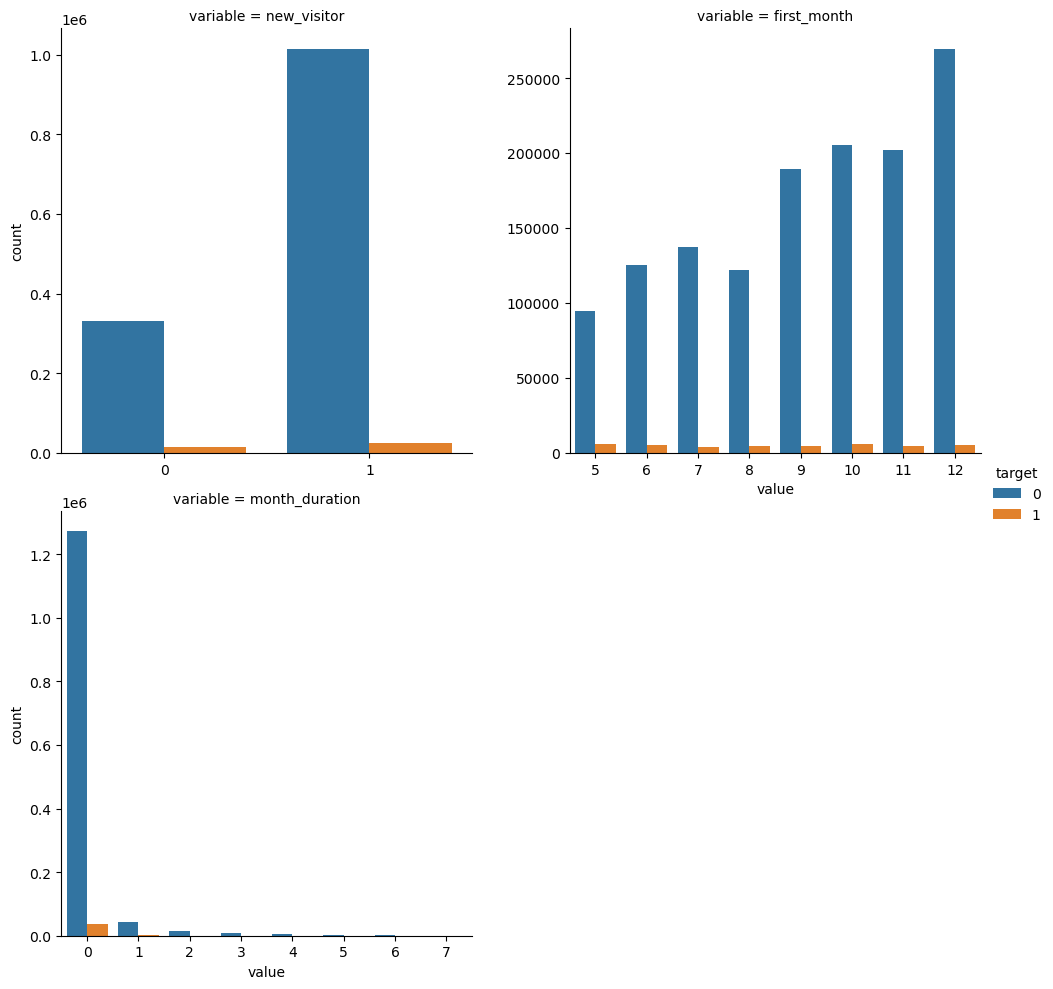

In [63]:
g=sns.catplot(
    x='value',
    hue='target',
    data=df_train.melt(
        id_vars=['target'],
        value_vars=['new_visitor', 'first_month', 'month_duration']
    ),
    col='variable',
    kind='count',
    col_wrap=2,
    sharex=False,
    sharey=False,
);

Как видно, большинство визитов совершается новыми пользователями. По признаку **month_duration** можно увидеть, что в основном целевые дейстия совершаются пользователями в течение первого месяца. Что касается признака **first_month**, то его поведение очень похоже на признак **visit_month**

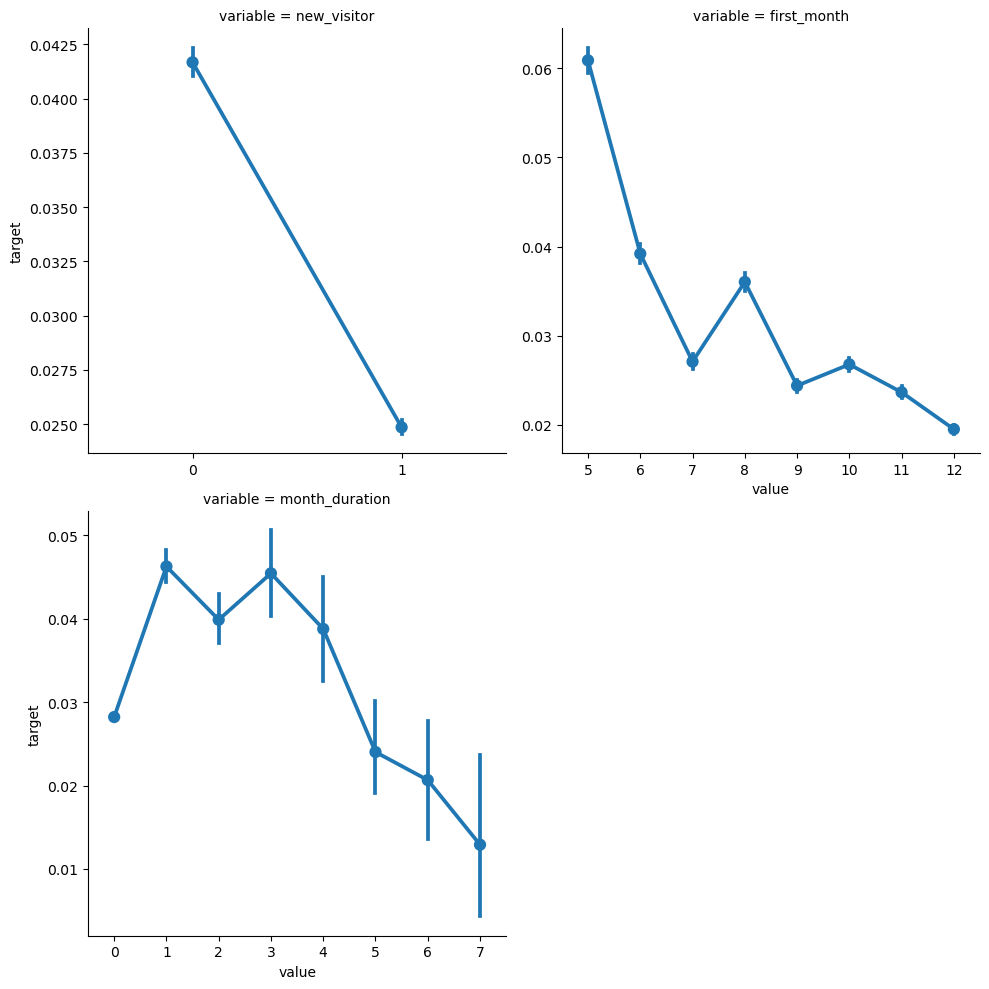

In [33]:
g=sns.catplot(
    x='value',
    y='target',
    data=df_train.melt(
        id_vars=['target'],
        value_vars=['new_visitor', 'first_month', 'month_duration']
    ),
    col='variable',
    kind='point',
    col_wrap=2,
    sharex=False,
    sharey=False,
);

Из этих графиков видно, что в среднем целевые действия совершаются реже новыми пользователями. После пятого месяца активность пользователей уменьшается

Создадим ещё признаки. Отдельно выделим органический трафик, так как помним, что через него совершается немалая доля целевых действий

In [32]:
organic = ['organic', 'referral', '(none)']

# 1 - органический трафик, 0 - нет
df_train['organic'] = df_train.utm_medium.map(lambda x: ('Yes' if x in organic else 'No')
                                              if not pd.isna(x) else x)

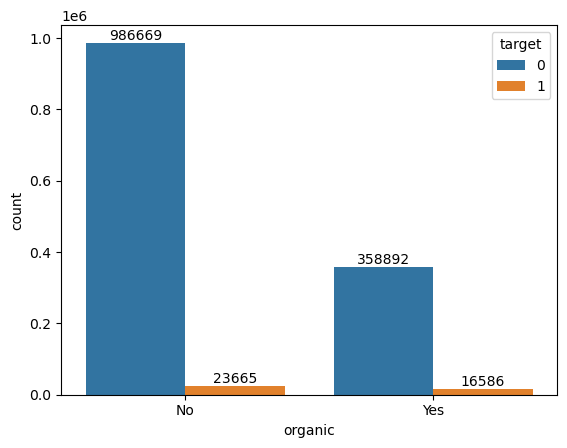

In [55]:
g = sns.countplot(
    x='organic',
    hue='target',
    data=df_train,
)
for container in g.containers:
    g.bar_label(container)

Визуально видно, что процент целевых действий для органического трафика относительно высокий, если сравнивать с платным трафиком

Исследуем влияние социальных сетей

In [33]:
social = [
    'QxAxdyPLuQMEcrdZWdWb',
    'MvfHsxITijuriZxsqZqt',
    'ISrKoXQCxqqYvAZICvjs', 
    'IZEXUFLARCUMynmHNBGo', 
    'PlbkrSYoHuZBWfYjYnfw', 
    'gVRrcxiDQubJiljoTbGm'
]

# 1 - социальная сеть, 0 - нет
df_train['social'] = df_train.utm_source.map(lambda x: ('Yes' if x in social else 'No')
                                             if not pd.isna(x) else x)

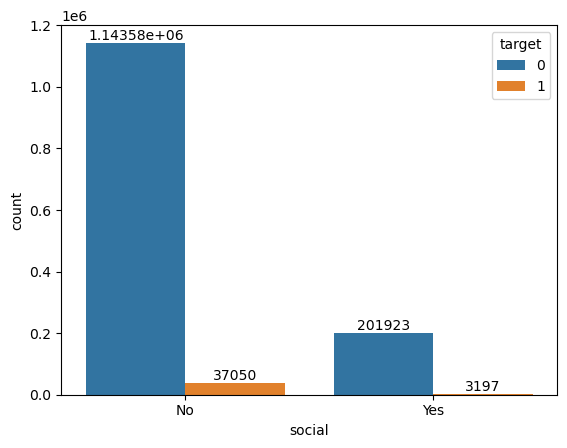

In [57]:
g = sns.countplot(
    x='social',
    hue='target',
    data=df_train,
)
for container in g.containers:
    g.bar_label(container)

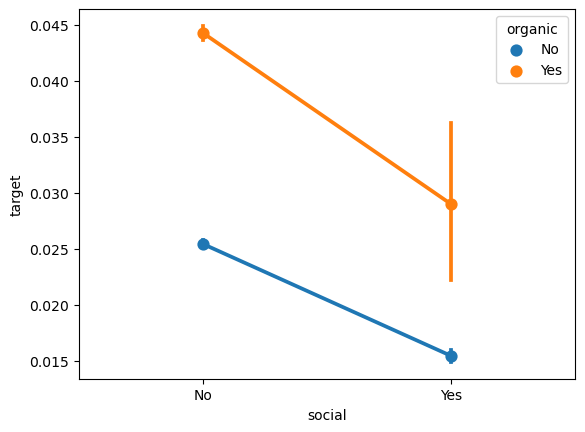

In [58]:
sns.pointplot(
    y='target',
    x='social',
    data=df_train,
    hue='organic'
);

Как видно, пользователи, привлечённые через социальные сети гораздо реже совершают целевые действия

Под конец рассмотрим корреляции признаков

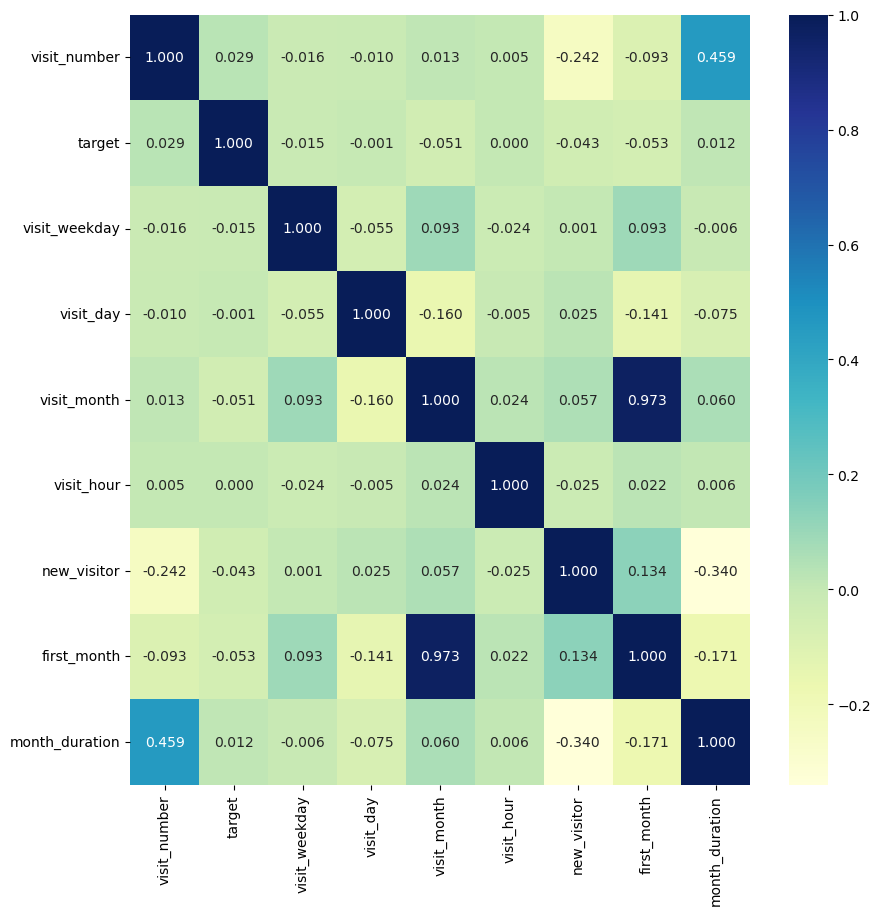

In [34]:
plt.figure(figsize=(10,10))
sns.heatmap(
    df_train.corr(), 
    annot=True, 
    cmap='YlGnBu',
    fmt='.3f',
);

In [35]:
df_train.corr()['target'].sort_values(ascending=False)

target            1.000000
visit_number      0.029009
month_duration    0.012252
visit_hour        0.000467
visit_day        -0.000715
visit_weekday    -0.014861
new_visitor      -0.043314
visit_month      -0.051060
first_month      -0.053216
Name: target, dtype: float64

Можно заметить очень слабые корреляции с целевыми значениями. Поэтому ожидать высокой точности от наших моделей не стоит

## 5. Моделирование <a class="anchor" id="5"></a>

### 5.1 Базовые оценки <a class="anchor" id="5.1"></a>

[Наверх](#0)

Обновим значения для обучения

In [36]:
df_train = df_train.drop(['session_id', 'client_id'], axis=1)

In [37]:
X_train = df_train[:100000].drop('target', axis=1)
y_train = df_train[:100000].target.copy()

In [38]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 100000 entries, 235446 to 347625
Data columns (total 23 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   visit_date       100000 non-null  datetime64[ns]
 1   visit_time       100000 non-null  datetime64[ns]
 2   visit_number     100000 non-null  int64         
 3   utm_source       99995 non-null   object        
 4   utm_medium       100000 non-null  object        
 5   utm_campaign     88761 non-null   object        
 6   utm_adcontent    82680 non-null   object        
 7   utm_keyword      41353 non-null   object        
 8   device_category  100000 non-null  object        
 9   device_os        41735 non-null   object        
 10  device_brand     80154 non-null   object        
 11  device_browser   100000 non-null  object        
 12  geo_country      100000 non-null  object        
 13  geo_city         100000 non-null  object        
 14  visit_weekday  

In [39]:
cat_columns = X_train.select_dtypes(object).columns
cat_columns

Index(['utm_source', 'utm_medium', 'utm_campaign', 'utm_adcontent',
       'utm_keyword', 'device_category', 'device_os', 'device_brand',
       'device_browser', 'geo_country', 'geo_city', 'organic', 'social'],
      dtype='object')

In [40]:
num_columns = X_train.select_dtypes(int).columns
num_columns

Index(['visit_number', 'visit_weekday', 'visit_day', 'visit_month',
       'visit_hour', 'new_visitor', 'first_month', 'month_duration'],
      dtype='object')

In [41]:
full_prep = ColumnTransformer([
    ('cat', cat_pipeline, cat_columns),
    ('num', num_pipeline, num_columns),
])

In [42]:
X_train_encoded = full_prep.fit_transform(X_train)

In [39]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    svm_clf,
    tre_clf, 
    rnd_clf, 
    ext_clf
    ):
    score = cross_val_score(clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, scoring='roc_auc')                            
    print(f'{clf.__class__.__name__}: ROC_AUC = {score.mean():0.3f} ± {score.std():0.3f}')

SGDClassifier: ROC_AUC = 0.643 ± 0.020
LogisticRegression: ROC_AUC = 0.664 ± 0.009
LinearSVC: ROC_AUC = 0.655 ± 0.010
SVC: ROC_AUC = 0.598 ± 0.002
DecisionTreeClassifier: ROC_AUC = 0.517 ± 0.006
RandomForestClassifier: ROC_AUC = 0.615 ± 0.010
ExtraTreeClassifier: ROC_AUC = 0.514 ± 0.003


Как видно, для **LogisticRegression** и **LinearSVC** оценки немного улучшились, чего нельзя сказать про остальные классификаторы. Попробуем настроить некоторые модели

### 5.2 SGDClassifier <a class="anchor" id="5.2"></a>

[Наверх](#0)

Для тюнинга гиперпараметров воспользуемся **HyperOpt**. Определим несколько вспомогательных функций

In [43]:
# Кросс-валидация с текущими гиперпараметрами
def objective(params, model,  X_train, y_train):
    model.set_params(**params)
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
    score = cross_val_score(model, X_train, y_train, scoring='roc_auc', cv=skf, n_jobs=-1)
    return   {'loss': -score.mean(), 'params': params, 'loss_std': -score.std(), 'status': STATUS_OK}

In [44]:
# Для отображения результатов 
def get_results(hp_results):
    results = pd.DataFrame([
        {**x, **{'loss_func' if k == 'loss' else k:v for k,v in x['params'].items()}} 
        for x in  hp_results
    ])
    results.drop(['status', 'params'], axis=1, inplace=True)
    results.sort_values(by=['loss'], ascending=True, inplace=True)
    return results

Зададим ещё раз модель и определим пространство гиперпараметров

In [42]:
sgd_clf = SGDClassifier(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)

In [58]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : hp.choice('penalty1', ['l1', 'l2']),
        'alpha': hp.uniform('alpha1', 1e-4, 1e-2),
        'early_stopping' : hp.choice('early_stopping1', [False, True]),
        'loss' : hp.choice('loss1', ['log', 'hinge', 'modified_huber', 'squared_hinge', 'huber']),
    },
    {
        'penalty' : 'elasticnet',
        'l1_ratio': hp.uniform('l1_ratio', 0, 1),
        'alpha': hp.uniform('alpha2', 1e-4, 1e-2),
        'early_stopping' : hp.choice('early_stopping2', [False, True]),
        'loss' : hp.choice('loss2', ['log', 'hinge', 'modified_huber', 'squared_hinge', 'huber']),
    },
])

In [62]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=sgd_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [05:14<00:00,  3.14s/trial, best loss: -0.6738579266653224]


In [63]:
best

{'alpha': 0.0009629534477900721,
 'early_stopping': False,
 'loss': 'log',
 'penalty': 'l2'}

In [64]:
result = get_results(trials.results)
result

,loss,loss_std,alpha,early_stopping,loss_func,penalty,l1_ratio
42,-0.673858,-0.011642,0.000963,False,log,l2,NaN
92,-0.673857,-0.011659,0.000980,False,log,l2,NaN
95,-0.673856,-0.011687,0.001006,False,log,l2,NaN
41,-0.673828,-0.011735,0.001047,False,log,l2,NaN
73,-0.673722,-0.011594,0.001847,False,log,l2,NaN
...,...,...,...,...,...,...,...
0,-0.586435,-0.024459,0.008851,True,squared_hinge,l2,NaN
43,-0.582428,-0.024640,0.000854,True,squared_hinge,l2,NaN
45,-0.580181,-0.006599,0.000165,True,hinge,l2,NaN
38,-0.558294,-0.017335,0.001536,False,squared_hinge,l2,NaN


Лучший ROC_AUC равен 0.67

In [65]:
sgd_clf.set_params(**best)

SGDClassifier(alpha=0.0009629534477900721, class_weight='balanced',
              l1_ratio=0.07206322884466193, loss='log', n_jobs=-1,
              random_state=42)

### 5.3 LogisticRegression <a class="anchor" id="5.3"></a>

[Наверх](#0)

In [49]:
log_clf = LogisticRegression(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)

In [50]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : 'l1',
        'C': hp.uniform('C1', 1e-4, 1e2),
        'solver' : hp.choice('solver1', ['liblinear', 'saga']),
    },
    {
        'penalty' : 'l2',
        'C': hp.uniform('C2', 1e-4, 1e2),
        'solver' : hp.choice('solver2', ['newton-cg', 'lbfgs', 'sag', 'saga', 'liblinear']),
    },
    {
        'penalty' : 'none',
        'C': hp.uniform('C3', 1e-4, 1e2),
        'solver' : hp.choice('solver3', ['newton-cg', 'lbfgs', 'sag', 'saga']),
    },
    {
        'penalty' : 'elasticnet',
        'C': hp.uniform('C4', 1e-4, 1e2),
        'solver' : 'saga',
        'l1_ratio': hp.uniform('l1_ratio', 0, 1)
    },
])

In [ ]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=log_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

In [49]:
best

{'C': 0.10260281782843347,
 'l1_ratio': 0.9349406984288822,
 'penalty': 'elasticnet',
 'solver': 'saga'}

In [50]:
result = get_results(trials.results)
result

,loss,loss_std,C,penalty,solver,l1_ratio
94,-0.677776,-0.011526,0.102603,elasticnet,saga,0.934941
66,-0.676690,-0.012479,0.036040,elasticnet,saga,0.670585
72,-0.676522,-0.010867,0.137080,elasticnet,saga,0.455990
25,-0.675038,-0.012614,0.033035,elasticnet,saga,0.812868
33,-0.674409,-0.010573,0.511920,elasticnet,saga,0.395665
...,...,...,...,...,...,...
97,-0.654908,-0.009213,98.356707,none,newton-cg,NaN
55,-0.654908,-0.009213,29.648190,none,newton-cg,NaN
19,-0.654842,-0.009445,71.304481,l1,liblinear,NaN
63,-0.654789,-0.009418,86.534777,l1,liblinear,NaN


Лучший ROC_AUC равен 0.67

In [51]:
log_clf.set_params(**best)

LogisticRegression(C=0.10260281782843347, class_weight='balanced',
                   l1_ratio=0.9349406984288822, n_jobs=1, penalty='elasticnet',
                   random_state=42, solver='saga')

### 5.4 LinearSVC <a class="anchor" id="5.4"></a>

[Наверх](#0)

In [86]:
svc_clf = LinearSVC(random_state=42, class_weight='balanced')

In [87]:
param_grid = hp.choice('penalty',[
    {
        'penalty' : 'l2',
        'C': hp.uniform('C2', 1e-4, 1e3),
        'loss' : hp.choice('loss1', ['hinge', 'squared_hinge']),
        'dual': True
    },
    {
        'penalty' : 'l1',
        'C': hp.uniform('C1', 1e-4, 1e3),
        'loss' : hp.choice('loss2', ['squared_hinge']),
        'dual': False
    }
])

In [88]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=svc_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [27:11<00:00, 16.31s/trial, best loss: -0.6615571891348888]


In [89]:
best

{'C': 0.49954604810506653,
 'dual': False,
 'loss': 'squared_hinge',
 'penalty': 'l1'}

In [90]:
result = get_results(trials.results)
result

,loss,loss_std,C,dual,loss_func,penalty
70,-0.661557,-0.009736,0.499546,False,squared_hinge,l1
27,-0.658998,-0.009825,1.451940,False,squared_hinge,l1
65,-0.658871,-0.009576,1.488397,False,squared_hinge,l1
26,-0.658772,-0.009791,1.461133,False,squared_hinge,l1
72,-0.657987,-0.009551,3.113169,False,squared_hinge,l1
...,...,...,...,...,...,...
63,-0.539550,-0.026994,454.163724,True,hinge,l2
50,-0.539550,-0.026994,915.481648,True,hinge,l2
80,-0.539550,-0.026994,875.300370,True,hinge,l2
47,-0.530168,-0.029313,500.100917,True,squared_hinge,l2


Лучший ROC_AUC равен 0.66, что немного хуже, чем для логистической регрессии

In [91]:
svc_clf.set_params(**best)

LinearSVC(C=0.49954604810506653, class_weight='balanced', dual=False,
          penalty='l1', random_state=42)

### 5.5 RandomForestClassifier <a class="anchor" id="5.5"></a>

[Наверх](#0)

In [68]:
rnd_clf = RandomForestClassifier(
    random_state=42, 
    class_weight='balanced',
    n_jobs=-1
)

In [69]:
param_grid = {
    'max_depth': hp.randint('max_depth', 1, 100),
    'max_leaf_nodes': hp.randint('max_leaf_nodes', 1, 100),
    'min_samples_leaf': hp.randint('min_samples_leaf', 1, 100),
    'min_samples_split': hp.randint('min_samples_split', 2, 100),
    'n_estimators': hp.randint('n_estimators', 100, 1000),
    'max_samples': hp.uniform('max_samples', 0, 1),
}

In [70]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=rnd_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [59:53<00:00, 35.94s/trial, best loss: -0.6774880385503117] 


In [71]:
best

{'max_depth': 80,
 'max_leaf_nodes': 94,
 'max_samples': 0.9154067950495719,
 'min_samples_leaf': 12,
 'min_samples_split': 71,
 'n_estimators': 532}

In [72]:
result = get_results(trials.results)
result

,loss,loss_std,max_depth,max_leaf_nodes,max_samples,min_samples_leaf,min_samples_split,n_estimators
70,-0.677488,-0.011834,80,94,0.915407,12,71,532
68,-0.677423,-0.011046,84,95,0.859371,8,71,147
66,-0.677321,-0.010855,64,95,0.768083,8,49,202
65,-0.676838,-0.012168,84,74,0.904536,8,49,823
57,-0.676531,-0.011619,90,74,0.780783,8,49,595
...,...,...,...,...,...,...,...,...
10,-0.648605,-0.012801,39,5,0.268325,53,5,157
34,-0.647744,-0.010799,52,3,0.353290,71,32,658
55,-0.645786,-0.011475,2,91,0.293316,94,50,200
51,-0.644877,-0.008966,58,2,0.619932,11,66,201


Лучший ROC_AUC равен 0.67

In [74]:
rnd_clf.set_params(**best)

RandomForestClassifier(class_weight='balanced', max_depth=80, max_leaf_nodes=94,
                       max_samples=0.9154067950495719, min_samples_leaf=12,
                       min_samples_split=71, n_estimators=532, n_jobs=-1,
                       random_state=42)

### 5.6 VotingClassifier <a class="anchor" id="5.6"></a>

[Наверх](#0)

Мы получили в целом неплохие оценки, но попробуем улучшить результат с помощью классификатора с голосованием. Воспользуемся схемой c "мягким" голосованием

In [82]:
# voting = 'soft'
vot_clf = VotingClassifier(estimators=[('log', log_clf), ('rnd', rnd_clf)], n_jobs=-1, voting='soft')

In [84]:
score = cross_val_score(vot_clf, X_train_encoded, y_train, cv=skf, n_jobs=-1, scoring='roc_auc', error_score='raise')                            
print(f'{vot_clf.__class__.__name__}: ROC_AUC = {score.mean():0.3f} ± {score.std():0.3f}')

VotingClassifier: ROC_AUC = 0.683 ± 0.012


### 5.7 Тест полученных моделей <a class="anchor" id="5.7"></a>

[Наверх](#0)

Проведём тестирование на полном датасете. Для этого надо провести все необходимые преобразования над тестовым датасетом, а модели обучить на полном наборе данных тренировочного датасета

In [57]:
X_full_train = df_train.drop('target', axis=1)
y_full_train = df_train.target.copy()

In [58]:
X_full_train_encoded = full_prep.fit_transform(X_full_train)

Для автоматизации рутины определим функции и конвейеры

In [61]:
def filter_data(df):
    columns_to_drop = [
        'device_model',
        'device_screen_resolution',
    ]
    return df.drop(columns_to_drop, axis=1)

In [62]:
def obj_to_date(df):
    df = df.copy()
    df['visit_date'] = pd.to_datetime(df['visit_date'].map(lambda x: str(x)))
    df['visit_time'] = pd.to_datetime(df['visit_time'].map(lambda x: str(x)))
    return df

In [63]:
def new_features(df):
    df = df.copy()
    organic = ['organic', 'referral', '(none)']
    social = [
        'QxAxdyPLuQMEcrdZWdWb',
        'MvfHsxITijuriZxsqZqt',
        'ISrKoXQCxqqYvAZICvjs', 
        'IZEXUFLARCUMynmHNBGo', 
        'PlbkrSYoHuZBWfYjYnfw', 
        'gVRrcxiDQubJiljoTbGm'
    ]
    df['visit_weekday'] = df.visit_date.dt.weekday.astype(int)
    df['visit_month'] = df.visit_date.dt.month.astype(int)
    df['visit_day'] = df.visit_date.dt.day.astype(int)
    df['visit_hour'] = df.visit_time.dt.hour.astype(int)
    df['new_visitor'] = df.visit_number.map(lambda x: 1 if x==1 else 0)
    df['first_month'] = df.groupby('client_id').visit_month.transform('min')
    df['month_duration'] = df.apply(lambda x: x.visit_month-x.first_month, axis=1)
    df['organic'] = df.utm_medium.map(lambda x: ('Yes' if x in organic else 'No')
                                      if not pd.isna(x) else x)
    df['social'] = df.utm_source.map(lambda x: ('Yes' if x in social else 'No')
                                     if not pd.isna(x) else x)
    return df

In [64]:
add_features = Pipeline(steps=[
    ('date', FunctionTransformer(obj_to_date)),
    ('features', FunctionTransformer(new_features)),
    ('filter', FunctionTransformer(filter_data)),
])

In [65]:
df_test = add_features.fit_transform(df_test)

In [66]:
X_full_test = df_test.drop('target', axis=1)
y_full_test = df_test.target.copy()

In [67]:
X_full_test_encoded = full_prep.transform(X_full_test)

In [68]:
def make_scores(y_train, y_pred):
    print(f'accuracy_score = {accuracy_score(y_train, y_pred):0.3f} \n'
          f'precision_score = {precision_score(y_train, y_pred):0.3f} \n'
          f'recall_score = {recall_score(y_train, y_pred):0.3f} \n'
          f'f1_score = {f1_score(y_train, y_pred):0.3f} \n'
          f'roc_auc = {roc_auc_score(y_train, y_pred):0.3f} \n'
          '************************'
         )

Проведём проверку

In [61]:
for clf in (
    sgd_clf, 
    log_clf, 
    svc_clf,
    rnd_clf, 
    vot_clf
    ):
    clf.fit(X_full_train_encoded, y_full_train)
    y_test_pred = clf.predict(X_full_test_encoded)
    print(clf.__class__.__name__)
    make_scores(y_full_test, y_test_pred)

SGDClassifier
accuracy_score = 0.590 
precision_score = 0.047 
recall_score = 0.673 
f1_score = 0.087 
roc_auc = 0.630 
************************
LogisticRegression
accuracy_score = 0.599 
precision_score = 0.048 
recall_score = 0.677 
f1_score = 0.089 
roc_auc = 0.637 
************************
LinearSVC
accuracy_score = 0.598 
precision_score = 0.047 
recall_score = 0.672 
f1_score = 0.089 
roc_auc = 0.634 
************************
RandomForestClassifier
accuracy_score = 0.556 
precision_score = 0.045 
recall_score = 0.704 
f1_score = 0.084 
roc_auc = 0.628 
************************
VotingClassifier
accuracy_score = 0.588 
precision_score = 0.047 
recall_score = 0.692 
f1_score = 0.089 
roc_auc = 0.638 
************************


Как видно, лучшмй результат на тестовой выборке показал классификатор с голосованием. Но полученная точность не отвечает заданию. Попробуем более продвинутые модели

### 5.8 XGBClassifier <a class="anchor" id="5.8"></a>

[Наверх](#0)

Зададим классификатор

In [45]:
xgb_clf = XGBClassifier(
    random_state=42, 
    verbosity=0, 
    scale_pos_weight=33,
    objective='binary:logistic',
    tree_method='hist',
    eval_metric='auc',
    n_jobs=-1,
    n_estimators=200, 
    booster='gbtree',
)

In [46]:
param_grid = {
    'learning_rate': hp.uniform('learning_rate', 0.01, 1),
    'min_split_loss': hp.uniform('min_split_loss', 0, 300),
    'max_depth': hp.randint('max_depth', 1, 20),
    'subsample': hp.uniform('subsample', 0.5, 0.9),
}

In [47]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=xgb_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [08:42<00:00,  5.23s/trial, best loss: -0.6869506359070787]


In [48]:
best

{'learning_rate': 0.010153901624706588,
 'max_depth': 14,
 'min_split_loss': 56.25649142937595,
 'subsample': 0.6631445606963953}

In [49]:
result = get_results(trials.results)
result

,loss,loss_std,learning_rate,max_depth,min_split_loss,subsample
64,-0.686951,-0.009459,0.010154,14,56.256491,0.663145
26,-0.686801,-0.010692,0.012272,7,73.908173,0.720933
68,-0.686620,-0.010920,0.028124,7,43.157990,0.764049
20,-0.685995,-0.010191,0.022082,19,101.370340,0.735291
21,-0.685792,-0.010616,0.094880,19,99.180606,0.731835
...,...,...,...,...,...,...
91,-0.595031,-0.007147,0.837334,7,1.586595,0.682051
96,-0.593429,-0.007276,0.997827,10,39.418514,0.598744
82,-0.583761,-0.007651,0.873163,12,10.258645,0.619693
17,-0.574144,-0.007621,0.976760,17,30.924620,0.629980


Получилось самое большое значение ROC_AUC

In [50]:
xgb_clf.set_params(**best)

XGBClassifier(base_score=None, booster='gbtree', callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.010153901624706588,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=14, max_leaves=None,
              min_child_weight=None, min_split_loss=56.25649142937595,
              missing=nan, monotone_constraints=None, n_estimators=200,
              n_jobs=-1, num_parallel_tree=None, predictor=None, ...)

Обучим модель с оптимальными параметрами

In [55]:
xgb_clf.fit(X_train_encoded, y_train, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=56.2564926,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.010153901624706588,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              min_split_loss=56.25649142937595, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', ...)

Попробуем оценить какие признаки классификатор посчитал наиболее значимыми

In [56]:
sorted(zip(xgb_clf.feature_importances_, full_prep.get_feature_names_out()), reverse=True)[:10]

[(0.026328053, 'cat__utm_adcontent_JNHcPlZPxEMWDnRiyoBf'),
 (0.0076263826, 'cat__utm_campaign_FTjNLDyTrXaWYgZymFkV'),
 (0.0073261242, 'cat__utm_campaign_LTuZkdKfxRGVceoWkVyg'),
 (0.0054480606, 'cat__utm_source_ZpYIoDJMcFzVoPFsHGJL'),
 (0.005155709, 'num__first_month'),
 (0.004760062, 'cat__utm_medium_cpm'),
 (0.004675117, 'cat__utm_source_RmEBuqrriAfAVsLQQmhk'),
 (0.0041658976, 'cat__utm_medium_referral'),
 (0.0041640345, 'cat__utm_campaign_bxOTvPtyGSdUrbwoXCPO'),
 (0.0041359575, 'cat__utm_source_MvfHsxITijuriZxsqZqt')]

In [53]:
# Эта ячейка и ниже для версии sklearn 1.0.2
#cat_feat = full_prep.named_transformers_.cat.named_steps.encoder.get_feature_names_out()

In [54]:
#num_feat = full_prep.named_transformers_.num.named_steps.std_scaler.get_feature_names_out(num_columns)

In [55]:
#imp = np.concatenate((cat_feat, num_feat), axis=None)

In [56]:
#sorted(zip(xgb_clf.feature_importances_, imp), reverse=True)[:10]

В топ-10 фичей не попал номер визита! Хотя стоило ожидать, что этот признак довольно важен.

Обучим на всём тренировочном датасете

In [59]:
xgb_clf.fit(X_full_train_encoded, y_full_train, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=56.2564926,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.010153901624706588,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              min_split_loss=56.25649142937595, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', ...)

In [69]:
y_test_pred = xgb_clf.predict(X_full_test_encoded)

In [70]:
make_scores(y_full_test, y_test_pred)

accuracy_score = 0.670 
precision_score = 0.054 
recall_score = 0.628 
f1_score = 0.100 
roc_auc = 0.650 
************************


Отлично! Получили нужное значение! При этом видно, что точность составляет 5.4 %. Это всего лишь на 2.5 % больше вероятности угадать целевое действие. 

**Обучим модель на всём датасете!**

In [86]:
df = add_features.fit_transform(df)

In [87]:
X = df.drop('target', axis=1)
y = df.target.copy()

In [88]:
X_encoded = full_prep.fit_transform(X)

In [89]:
xgb_clf.fit(X_encoded, y, verbose=False)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='auc', feature_types=None, gamma=56.2564926,
              gpu_id=-1, grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.010153901624706588,
              max_bin=256, max_cat_threshold=64, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=14, max_leaves=0, min_child_weight=1,
              min_split_loss=56.25649142937595, missing=nan,
              monotone_constraints='()', n_estimators=200, n_jobs=-1,
              num_parallel_tree=1, predictor='auto', ...)

Сохраним модель

In [99]:
with open('xgb_model.pkl', 'wb') as file:
    dill.dump(xgb_clf, file)

Загрузим в случае необходимости

In [54]:
with open('xgb_model.pkl', 'rb') as file:
    xgb_clf = dill.load(file)

Попробуем ещё один классификатор

### 5.9 LGBMClassifier <a class="anchor" id="5.9"></a>

[Наверх](#0)

In [82]:
lgb_clf = LGBMClassifier(
    boosting='gbdt',
    n_estimators=200,
    class_weight='balanced',
    random_state=42,
    n_jobs=-1,
)

In [91]:
param_grid = {
    'num_leaves': hp.randint('num_leaves', 10, 50),
    'max_depth': hp.randint('max_depth', 50),
    'learning_rate': hp.uniform('learning_rate', 0.01, 0.1),
    'subsample': hp.uniform('subsample', 0.2, 0.9),
    'subsample_freq': hp.randint('subsample_freq', 1, 50),
}

In [92]:
trials = Trials()
best = fmin(
    fn=partial(objective, model=lgb_clf, X_train=X_train_encoded, y_train=y_train),
    space=param_grid,
    algo=tpe.suggest,
    max_evals=100,
    trials=trials,
    rstate=np.random.default_rng(42),
    show_progressbar=True,
    return_argmin=False
)

100%|██████████| 100/100 [08:24<00:00,  5.05s/trial, best loss: -0.6848462997226609]


In [93]:
best

{'learning_rate': 0.025884061971288445,
 'max_depth': 31,
 'num_leaves': 16,
 'subsample': 0.5100275177335386,
 'subsample_freq': 1}

In [94]:
result = get_results(trials.results)
result

,loss,loss_std,learning_rate,max_depth,num_leaves,subsample,subsample_freq
88,-0.684846,-0.014056,0.025884,31,16,0.510028,1
79,-0.684844,-0.012172,0.015391,0,31,0.521023,3
85,-0.684653,-0.013024,0.032785,15,34,0.578683,1
30,-0.684249,-0.012031,0.011222,16,36,0.389808,3
68,-0.684150,-0.011584,0.023035,30,21,0.875425,4
...,...,...,...,...,...,...,...
35,-0.655031,-0.016115,0.066597,35,24,0.291866,38
32,-0.654420,-0.015823,0.022140,16,36,0.202829,45
5,-0.650806,-0.012253,0.075083,30,40,0.312717,36
45,-0.649045,-0.014800,0.081719,17,49,0.268496,32


In [95]:
lgb_clf.set_params(**best)

LGBMClassifier(boosting='gbdt', class_weight='balanced',
               learning_rate=0.025884061971288445, max_depth=31,
               n_estimators=200, num_leaves=16, random_state=42,
               subsample=0.5100275177335386, subsample_freq=1)

In [96]:
lgb_clf.fit(X_full_train_encoded, y_full_train)

[LightGBM] [Warning] boosting is set=gbdt, boosting_type=gbdt will be ignored. Current value: boosting=gbdt


LGBMClassifier(boosting='gbdt', class_weight='balanced',
               learning_rate=0.025884061971288445, max_depth=31,
               n_estimators=200, num_leaves=16, random_state=42,
               subsample=0.5100275177335386, subsample_freq=1)

In [97]:
y_test_pred = lgb_clf.predict(X_full_test_encoded)

In [98]:
make_scores(y_full_test, y_test_pred)

accuracy_score = 0.605 
precision_score = 0.049 
recall_score = 0.678 
f1_score = 0.091 
roc_auc = 0.641 
************************


Оценка хуже чем у XGB, но лучше чем у других моделей

## 6. Валидация <a class="anchor" id="6"></a>

[Наверх](#0)

Загрузим датасет для финальной проверки

In [91]:
with open('data/ds_final_test_dataset.pkl', 'rb') as file:
    ds_final_test = dill.load(file)

In [92]:
target_events = [
    'sub_car_claim_click',
    'sub_car_claim_submit_click',
    'sub_open_dialog_click',
    'sub_custom_question_submit_click',
    'sub_call_number_click',
    'sub_callback_submit_click',
    'sub_submit_success',
    'sub_car_request_submit_click'
]

In [93]:
ds_final_test = add_features.transform(ds_final_test)

In [94]:
y_valid = ds_final_test.event_action.isin(target_events).astype(int)

In [95]:
X_valid = ds_final_test.drop('event_action', axis=1)

In [96]:
X_valid_encoded = full_prep.transform(X_valid)

In [97]:
y_pred = xgb_clf.predict(X_valid_encoded)

In [98]:
make_scores(y_valid, y_pred)

accuracy_score = 0.745 
precision_score = 0.006 
recall_score = 0.377 
f1_score = 0.013 
roc_auc = 0.562 
************************


Отлично, на закрытой тестовой выборке точность составила 0.562, что выше требуемого значения! 

## 7. Заключение <a class="anchor" id="7"></a>

[Наверх](#0)

Таким образом, нам удалось достигнуть необходимого значения метрики _ROC_AUC_ = 0.65 на тренировочной выборке с помощью _XGBClassifier_. На закрытой тестовой выборке точность составила 0.57, что тоже является приемлемым результатом. Остальным моделям достигнуть аналогичного результата не удалось.